# Import Libraries

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import NormalIndPower

userid - a unique number that identifies each player.

version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).

sum_gamerounds - the number of game rounds played by the player during the first week after installation

retention_1 - did the player come back and play 1 day after installing?

retention_7 - did the player come back and play 7 days after installing?

# Load Data

In [86]:
df = pd.read_csv('cookie_cats.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


The dataset has 5 columns, all of them with non-null values. The total size of the dataset is 90,189.

In [3]:
df.groupby(by='version').count().reset_index()

,version,userid,sum_gamerounds,retention_1,retention_7
0,gate_30,44700,44700,44700,44700
1,gate_40,45489,45489,45489,45489


The control and test groups are each split to contain approximately 50% of the data points.

# Descriptive Analysis

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


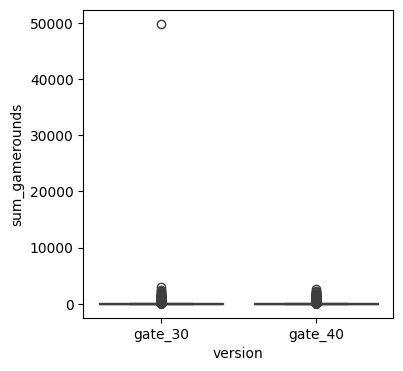

In [94]:
print(df['sum_gamerounds'].describe())
print(df.info())

plt.figure(figsize=(4,4))
sns.boxplot(
    data=df,
    y='sum_gamerounds',
    x='version'
)
plt.show()

In the control group at gate_30, it is possible to identify one player who played more than 50,000 rounds in one week (the duration of the test). This might indicate the presence of outliers in the dataset. To remove these outliers, I performed data cleaning using the IQR method.

In [106]:
def remove_outlier(df):
    q1 = np.quantile(df['sum_gamerounds'], 0.25)
    q3 = np.quantile(df['sum_gamerounds'], 0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    df = df.loc[
        (df['sum_gamerounds'] >= lower_bound) & 
        (df['sum_gamerounds'] <= upper_bound) 
    ]

    return df

df_clean = remove_outlier(df)

count    80012.000000
mean        23.979178
std         27.481366
min          0.000000
25%          4.000000
50%         13.000000
75%         34.000000
max        120.000000
Name: sum_gamerounds, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 80012 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          80012 non-null  int64 
 1   version         80012 non-null  object
 2   sum_gamerounds  80012 non-null  int64 
 3   retention_1     80012 non-null  bool  
 4   retention_7     80012 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.6+ MB
None


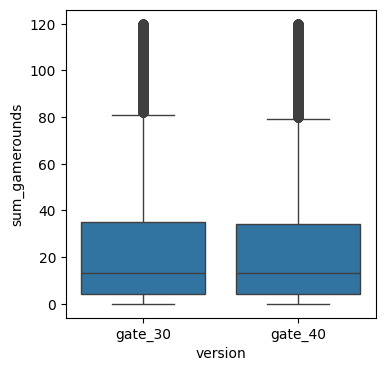

In [108]:
print(df_clean['sum_gamerounds'].describe())
print(df_clean.info())

plt.figure(figsize=(4,4))
sns.boxplot(
    data=df_clean,
    y='sum_gamerounds',
    x='version'
)
plt.show()

After cleaning the data, some interesting observations can be made:

- 25th Percentile: 25% of all users played around 4 rounds before stopping. This could be due to various factors, such as the game's design or players' different expectations regarding the game. Some players might have downloaded the game after seeing advertisements, but found that the actual gameplay did not meet their expectations. Additionally, some players might have downloaded the game expecting something different.

- Maximum Number of Rounds: The maximum number of rounds played in this distribution is 120. This suggests that regular players do not play more than 120 rounds, possibly due to limitations in level design or reaching the maximum level available to play. Although the data has been cleaned and there could be more levels available, the number 120 seems reasonable in the real-world context. Only a very few players reach this number of rounds.

- 75th Percentile: 75% of players stop at round 34, indicating that many players might stop playing after reaching the advertised gate.

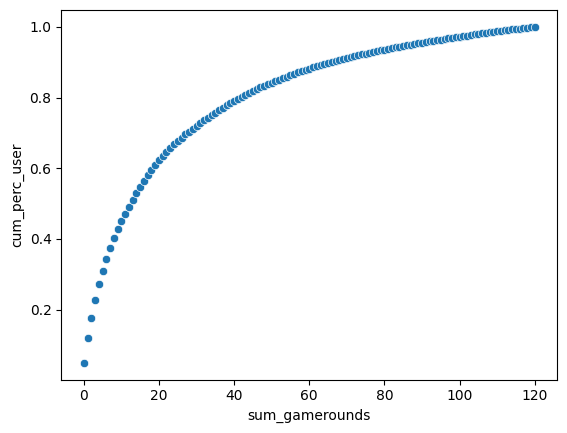

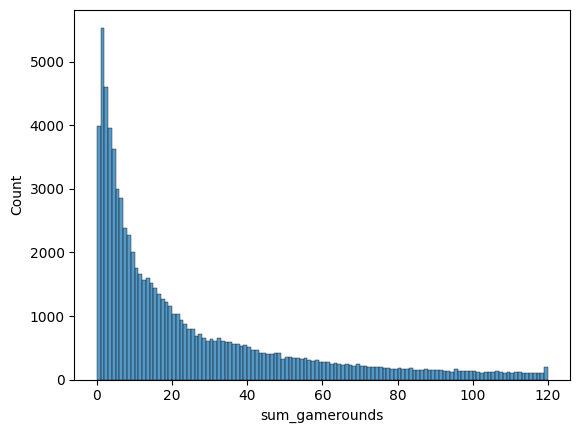

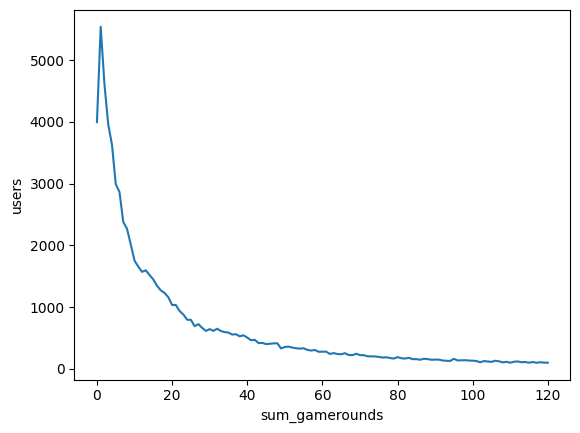

,sum_gamerounds,users,total_users,perc_user,cum_perc_user
0,0,3994,80012,0.049918,0.049918
1,1,5538,80012,0.069215,0.119132
2,2,4606,80012,0.057566,0.176698
3,3,3958,80012,0.049468,0.226166
4,4,3629,80012,0.045356,0.271522
...,...,...,...,...,...
116,116,110,80012,0.001375,0.994988
117,117,97,80012,0.001212,0.996201
118,118,106,80012,0.001325,0.997525
119,119,99,80012,0.001237,0.998763


In [112]:
df_perc_game = df_clean.groupby('sum_gamerounds')['userid'].count().reset_index()

df_perc_game = df_perc_game.rename(columns={'userid':'users'})

df_perc_game['total_users'] = np.sum(df_perc_game['users'])

df_perc_game['perc_user'] = df_perc_game['users'] / df_perc_game['total_users']

df_perc_game['cum_perc_user'] = df_perc_game['perc_user'].cumsum()

sns.scatterplot(
    data=df_perc_game[:500],
    x='sum_gamerounds',
    y='cum_perc_user'
)
plt.show()


sns.histplot(
    data=df_clean,
    x='sum_gamerounds',
    bins=120
)

plt.show()


sns.lineplot(
    data=df_perc_game[:500],
    x='sum_gamerounds',
    y='users')

plt.show()


df_perc_game

In [122]:
df_control = df_clean[df_clean['version']=='gate_30']['retention_1']
df_treat = df_clean[df_clean['version']=='gate_40']['retention_1']

n_control = len(df_control)
n_treat = len(df_treat)

success= [df_control.sum(),df_treat.sum()]
retention = [df_control.sum() / n_control,df_treat.sum() / n_treat]


nobs =[n_control,n_treat]

z_stats, pval = proportions_ztest(success,nobs=nobs)

print(f'n of observation for control : {n_control}')
print(f'n of observation for treatment : {n_treat}')
print(f'n of sucesses in control and treatment : {success} | {retention}')
print(f'z_stats : {z_stats}')
print(f'p-value: {pval}')

(array([0.3842967 , 0.37862292]), array([0.39389595, 0.38810814]))
n of observation for control : 39638
n of observation for treatment : 40374
n of sucesses in control and treatment : [15423, 15478] | [0.389096321711489, 0.38336553227324516]
z_stats : 1.6646506905825758
p-value: 0.09598246591228181


Regarding Retention 1, we observe a decrease in the treatment group (gate_40). Gate_30 shows a retention rate of 38.90%, while gate_40 shows a retention rate of 38.33%, indicating a possible reduction in retention when the gate is applied at level 40. After performing a z-test to determine if the difference is significant, the p-value found is 0.09. Our test was set up with an alpha of 0.05, so we accept the null hypothesis. This means we can say with 95% confidence that the difference is not significant, indicating that changing the gate from level 30 to 40 has no effect on 1-day retention.

If we consider a 90% confidence level, we would reject the null hypothesis, confirming with 90% confidence that the difference in retention is significant. Therefore, changing the gate from level 30 to 40 might affect 1-day retention.

In the scenario above, the results depend on how conservative the test is. In my opinion, we should always opt for a more conservative approach, reducing the possibility of errors.

In [118]:
df_control = df_clean[df_clean['version']=='gate_30']['retention_7']
df_treat = df_clean[df_clean['version']=='gate_40']['retention_7']

n_control = len(df_control)
n_treat = len(df_treat)

success= [df_control.sum(),df_treat.sum()]
retention = [df_control.sum() / n_control,df_treat.sum() / n_treat]


nobs =[n_control,n_treat]

z_stats,pval = proportions_ztest(success,nobs=nobs)

print(f'n of observation for control : {n_control}')
print(f'n of observation for treatment : {n_treat}')
print(f'n of sucesses in control and treatment : {success} | {retention}')
print(f'z_stats : {z_stats}')
print(f'p-value: {pval}')

n of observation for control : 39638
n of observation for treatment : 40374
n of sucesses in control and treatment : [4682, 4433] | [0.11811897673949241, 0.10979838509932134]
z_stats : 3.7037892049869834
p-value: 0.00021240277684542175


Regarding Retention 7, we observe a decrease in the treatment group, indicating a possible reduction in retention when the gate is applied at level 40 after 7 days. After performing a z-test to compare the proportions, the p-value is greater than 0.05, which indicates that we can be 95% certain there is an impact when moving the gate from level 30 to 40 on 7-day retention. Changing the gate to level 40 will decrease retention from 11.8% to 10.9%, nearly a 1% reduction.

These results can be explained by the initial excitement players feel when trying a new game, making them more willing to wait a little longer to continue playing. Over time, as the excitement wears off, players become less willing to wait and may stop playing because of the gate. Additionally, players might stop playing the game because they find it boring or too repetitive. Often, people play a game when they first install it and then forget about it. This could also be a factor, as players lose interest in the game over time.